This tutorial illustrates a simple usage of Loter for local ancestry inference.

## Table of Contents
* [I) Local Installation](#local_installation)
* [II) Quick overview](#loter_usage)
* [III) Running Loter from VCF Files](#vcf)


# I) Local Installation <a class="anchor" id="local_installation"></a>

For a global installation of Loter follow the procedure explain in the README.md at the top of the directory.
Here we demonstrate a simple way to directly use loter locally.
If you have already installed Loter, jump to [Loter usage](#loter_usage).

First, we need to compile the library

In [1]:
cd ..

/home/diasalvt/GitHub/Loter


In [2]:
!make

g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/init.cpp -o build/init.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/haplophase.cpp -o build/haplophase.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/estimatea/estimatea_c_api.cpp -o build/estimatea/estimatea_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/estimatea/estimatea.cpp -o build/estimatea/estimatea.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/data.cpp -o build/datastruct/data.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/parameter_opti.cpp -o build/datastruct/parameter_opti.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/parameter_c_api.cpp -o build/datastruct/parameter_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/data_c_api.cpp -o build/datastruct/data_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/graph/graph_c_api.cpp -o build/graph/graph_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/graph/graph.cpp -o build/graph/graph.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/parameter/m

If you do not have `OPENMP` installed on your computer, you'll need to desactivate this library.

In [9]:
!make no_omp=1

g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/init.cpp -o build/init.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/haplophase.cpp -o build/haplophase.o
src/haplophase.cpp:198:0: attention : #pragma omp parallel ignoré [-Wunknown-pragmas]
   #pragma omp parallel for
 ^
src/haplophase.cpp:205:0: attention : #pragma omp critical ignoré [-Wunknown-pragmas]
     #pragma omp critical
 ^
src/haplophase.cpp:244:0: attention : #pragma omp parallel ignoré [-Wunknown-pragmas]
   #pragma omp parallel for
 ^
src/haplophase.cpp:251:0: attention : #pragma omp critical ignoré [-Wunknown-pragmas]
     #pragma omp critical
 ^
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/estimatea/estimatea_c_api.cpp -o build/estimatea/estimatea_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/estimatea/estimatea.cpp -o build/estimatea/estimatea.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/datastruct/data.cpp -o build/datastruct/data.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src

In [3]:
cd python-package

/home/diasalvt/GitHub/Loter/python-package


Now we can directly use the Python package "loter" because we are in the good directory. If you installed `Loter` globally this is not necessary.

# II) Quick overview <a class="anchor" id='loter_usage'></a>

## a) Load Data <a  class="anchor" id='load_data'></a>

In [4]:
import numpy as np

H_ceu = np.load("../data/H_ceu.npy")
H_yri = np.load("../data/H_yri.npy")

In [5]:
H_ceu.shape

(88, 50000)

In [6]:
H_yri.shape

(100, 50000)

## b) Create a synthetic admixed individual <a class="anchor" id='admixed'></a>

In [7]:
H_met = np.copy(H_ceu[:2])

At the middle of the dataset, the ancestry switches between CEU and YRI.

In [8]:
pos_snp = H_yri.shape[1] / 2

In [9]:
print(pos_snp)

25000


In [10]:
H_met[:, pos_snp:] = H_yri[:2, pos_snp:]

## c) Run Loter <a class="anchor" id='run_loter'></a>

We exclude the 2 first individuals used to create the admixed individuals.

In [11]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_smooth([H_ceu[2:], H_yri[2:]], H_met)

## d) Visualize ancestry chunks <a class="anchor" id='plot_result'></a>

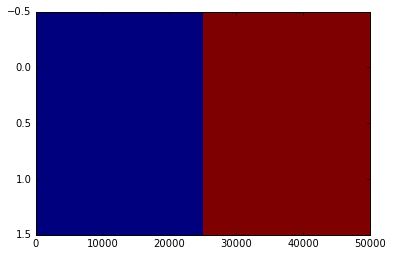

In [12]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_loter, interpolation='nearest', aspect='auto')

Where the switch appear in the result.

In [13]:
np.argwhere(np.diff(res_loter))

array([[    0, 24994],
       [    1, 24994]])

Notice you might find another result due to the stochastic nature of Loter.

# III) Running Loter from VCF Files <a class="anchor" id='vcf'></a>

To load a VCF, we use [scikit allel](https://scikit-allel.readthedocs.io/en/latest/#).

In [14]:
import allel

`vcf2npy` convert a VCF File to a numpy matrix with 0, 1 and 2.

In [15]:
def vcf2npy(vcfpath):
    callset = allel.read_vcf(vcfpath)
    haplotypes_1 = callset['calldata/GT'][:,:,0]
    haplotypes_2 = callset['calldata/GT'][:,:,1]
    
    m, n = haplotypes_1.shape
    mat_haplo = np.empty((2*n, m))
    mat_haplo[::2] = haplotypes_1.T
    mat_haplo[1::2] = haplotypes_2.T
    
    return mat_haplo.astype(np.uint8)

These 3 files are the results of the phasing software [Beagle](https://faculty.washington.edu/browning/beagle/beagle.html).

In [16]:
ceu_hap = vcf2npy('../data/ceu.vcf')
yri_hap = vcf2npy('../data/yri.vcf')
mex_hap = vcf2npy('../data/mex.vcf')

Finally, we run Loter with default parameters.
We assume, in this example, that Mexicans (*MEX*) are the result of admixture between Europeans (*CEU*) and Africans (*YRI*).
This computation may take several minutes to complete.

`loter_smooth` takes two arguments:
- a list of ancestral haplotypes matrices. Its length is equal to the number of ancestral populations.
- a matrix of admixed haplotypes

and returns the origin of each SNP.

In [17]:
import loter.locanc.local_ancestry as lc

mex_admixed = lc.loter_smooth([ceu_hap, yri_hap], mex_hap)

In [18]:
print(mex_admixed)

[[0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 [0 0 0 ..., 0 0 0]]


We display admixture chunks.
Chunks of zero correspond to CEU (first element of the list) and chunks of one correspond to YRI (second element of the list).

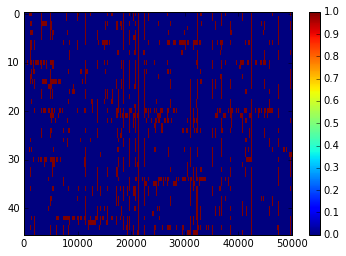

In [19]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(mex_admixed, interpolation='nearest', aspect='auto')
plt.colorbar()

Finally, we can save the result.
Each line correspond to an haplotype. The SNPs are space delimited.

In [20]:
np.savetxt("result_mex.txt", mex_admixed, fmt="%i")

## Dealing with more than 2 populations

It is not currently possible to account for phasing errors for more than two populations.

In [21]:
import loter.locanc.local_ancestry as lc

res_impute, res_no_impute = lc.loter_local_ancestry([ceu_hap, yri_hap, mex_hap], mex_hap)

The result for the haplotype can be found in the second variable 'res_no_impute'.
'res_no_impute[0]' contains the ancestry.
'res_no_impute[1]' contains the number of time that ancestry was picked.

'res_impute' contains the genotypic response.
The genotypic response represents the haplotypic ancestries without order.

The mapping function is the following:
g: (h1, h2) -> (max(h1, h2) * (max(h1, h2) + 1))/2 + min(h1, h2)

For example, let's consider 3 populations:
* g((0, 0)) = (0 * 1)/2 + 0 = 0

* g((0, 1)) = g((1, 0)) = (0 * 1)/2 + 1 = 1

* g((1, 1)) = (1 * 2)/2 + 1 = 2

* g((2, 0)) = g((0, 2)) = (2 * 3)/2 + 0 = 3

* g((2, 1)) = g((1, 2)) = (2 * 3)/2 + 1 = 4

* g((2, 2)) = (2 * 3)/2 + 2 = 5


So we are compressing the pair information into one single number.
It is useful for the computation of the genotypic acenstry error rate.

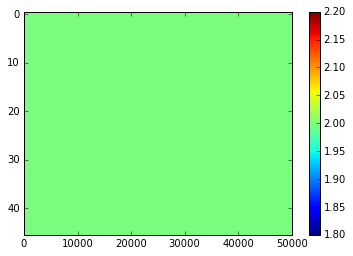

In [29]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_no_impute[0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [27]:
res_no_impute[0]

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ..., 
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])